In [1]:
import os
import glob
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/home/andres/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Temperature difference
diffs = pd.read_csv('diff.csv', delimiter=',')
diffs.head()

df = diffs

In [3]:
from pyproj import Transformer

# Transform coordinates from ETRS89 to WGS 84 / UTM zone 30N
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:25830')

# Iterate over each station
for index, row in df.iterrows():
    xx = row['lat']
    yy = row['lon']
    lat, lon = transformer.transform(xx, yy)
    # Update coordinates in dataset
    df.at[index, 'lat'] = lat
    df.at[index, 'lon'] = lon

In [4]:
df.head()

,station,temp_diff,lat,lon
0,4,3.847117,439579.3291,4475049.263
1,8,3.908468,442117.2366,4474770.696
2,16,3.634286,445786.1729,4476796.019
3,18,4.260863,437891.6961,4471832.769
4,24,2.925969,436598.5637,4474571.618


In [5]:
# Go to raster directory
raster_dir = './rasters'
os.chdir(raster_dir)

In [6]:
# List all .tif files
list = glob.glob('*.tif')
list

['Madrid_ETR89_MDS05.tif',
 'Madrid_ETRS89_NDVI.tif',
 'Madrid_ETR89_IMD.tif',
 'Madrid_ETR89_SVF.tif']

EPSG:25830


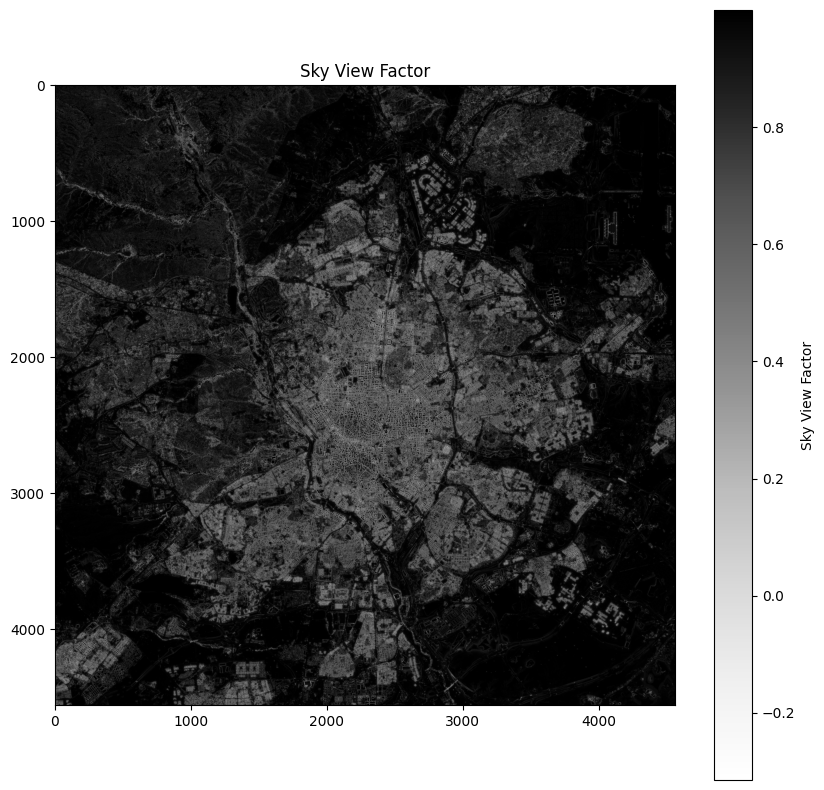

In [23]:
svf_raster_path = 'Madrid_ETR89_SVF.tif'
with rasterio.open(svf_raster_path) as src:
    print(src.crs)
    svf = src.read(1)

    '''# Extract coordinates for each pixel
    coords = np.array([src.transform * (col, row)
                       for row in range(src.height)
                       for col in range(src.width)])

    lons, lats = coords[:, 0], coords[:, 1]'''

    # Get SVF values
    svfs = []
    for index, station in df.iterrows():
        # Convert the coordinates (lat, lon) to row and column
        row, col = src.index(station['lat'], station['lon'])
        
        # Read the value of the pixel
        svf_value = src.read(1)[row, col]
        svfs.append(svf_value)
    df['svf'] = svfs
    
    
plt.figure(figsize=(10, 10))
plt.imshow(svf, cmap='Grays')
plt.colorbar(label='Sky View Factor')
plt.title(f'Sky View Factor')
plt.show()

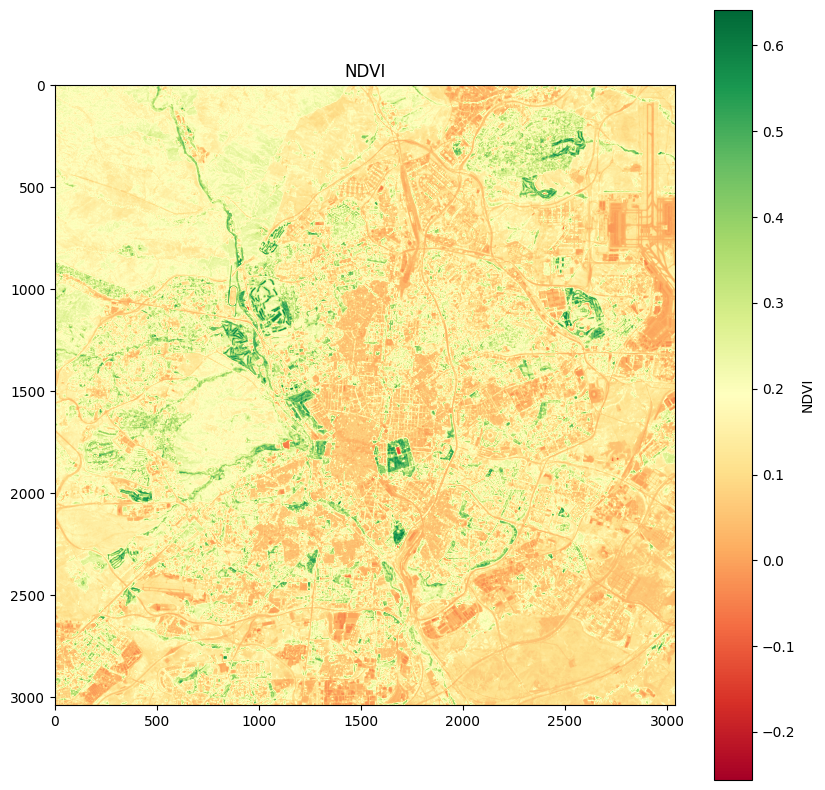

In [26]:
ndvi_raster_path = 'Madrid_ETRS89_NDVI.tif'
scale = 2
with rasterio.open(ndvi_raster_path) as src:
    #ndvi = src.read(1)
    ndvi = src.read(
        out_shape=(
            src.count,
            int(3039), # src.height * scale
            int(3039) # src.width * scale
        ),
        resampling = Resampling.bilinear
    )[0]

    # Get NDVI values
    ndvis = []
    for index, station in df.iterrows():
        # Convert the coordinates (lat, lon) to row and column
        row, col = src.index(station['lat'], station['lon'])
        
        # Read the value of the pixel
        ndvi_value = ndvi[row, col]
        ndvis.append(ndvi_value)
    df['ndvi'] = ndvis
    
plt.figure(figsize=(10, 10))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.title(f'NDVI')
plt.show()

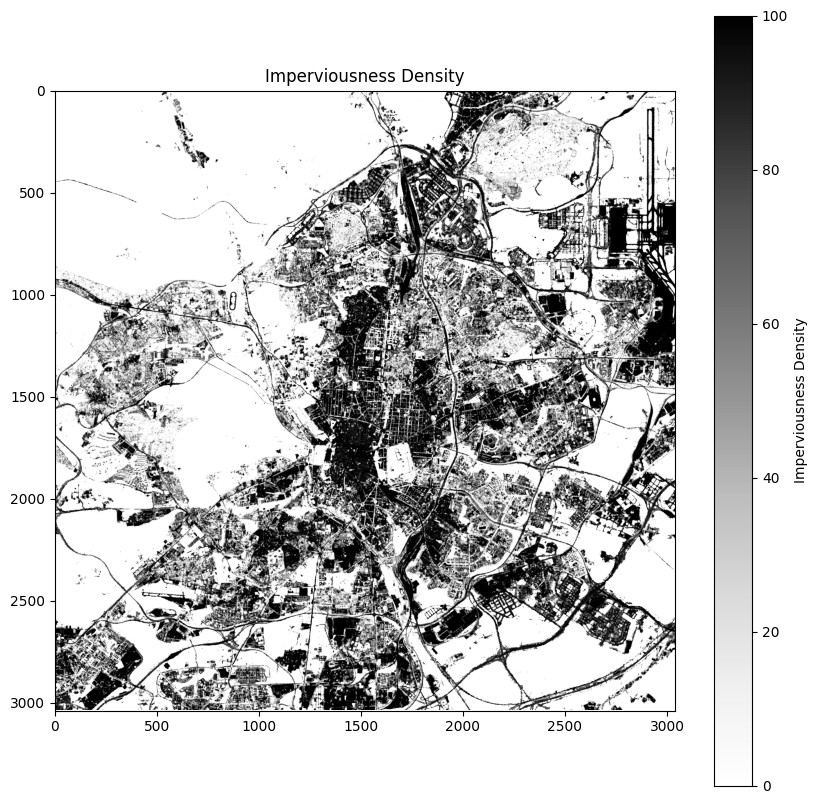

In [28]:
imd_raster_path = 'Madrid_ETR89_IMD.tif'
with rasterio.open(imd_raster_path) as src:
    #imd = src.read(1)
    imd = src.read(
        out_shape=(
            src.count,
            int(3039), # src.height * scale
            int(3039) # src.width * scale
        ),
        resampling = Resampling.bilinear
    )[0]

    # Get IMD values
    imds = []
    for index, station in df.iterrows():
        # Convert the coordinates (lat, lon) to row and column
        row, col = src.index(station['lat'], station['lon'])
        
        # Read the value of the pixel
        imd_value = imd[row, col]
        #print(imd_value)
        imds.append(imd_value)
    df['imd'] = imds
    
plt.figure(figsize=(10, 10))
plt.imshow(imd, cmap='Grays')
plt.colorbar(label='Imperviousness Density')
plt.title(f'Imperviousness Density')
plt.show()

In [29]:
df.head()

,station,temp_diff,lat,lon,svf,ndvi,imd
0,4,3.847117,439579.3291,4475049.263,0.578153,0.107843,74
1,8,3.908468,442117.2366,4474770.696,0.720239,0.329171,0
2,16,3.634286,445786.1729,4476796.019,0.675009,0.198323,63
3,18,4.260863,437891.6961,4471832.769,0.385797,0.187602,0
4,24,2.925969,436598.5637,4474571.618,0.990001,0.104219,52


In [30]:
# Export
df.to_csv('../data.csv', index=False)